In [76]:
############################# IMPORT STATEMENTS ########################################################
#Import Python modules
import librosa as librosa
import librosa.display
import numpy as np
import scipy as sp
import scipy.io.wavfile as wav
import IPython.display as ipd
import matplotlib.pyplot as plt


#Import Keras modules
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

from keras.layers import Dense, Flatten, Input, Conv1D, Conv2D, LSTM, Concatenate, Reshape, MaxPool1D, MaxPool2D, BatchNormalization
from keras import Model
from keras.optimizers import Adam
from keras.utils import np_utils
import keras.backend as K

In [204]:
############################# SETUP PROJECT PARAMETERS ########################################################
LOAD_PROGRESS_FROM_MODEL = False
SAVE_PROGRESS_TO_MODEL = True

In [78]:
nr_emotions = 7
block_size = 3
sampling_rate = 16000     ## 22050

data_location = "C:/Users/Tobias/Desktop/Master-Thesis/Data/EmoDB/wav/train"

filename = "/03a01Fa."
filetype = "wav"
learning_rate = 0.001
totalEpisodes = 10

In [79]:
ipd.Audio(data_location + filename + filetype)

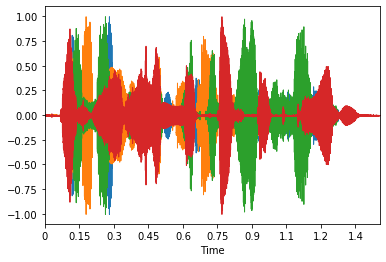

In [125]:
files = librosa.util.find_files(data_location, ext=['wav']) # include only wav files
files = np.asarray(files)

data = []
i = 0
for file in files:
    file_data = librosa.core.load(file, sr=sampling_rate ,mono = True)
    librosa.display.waveplot(file_data[0])
    data.append(file_data[0])

In [126]:
print(np.shape(data))
print(files)

(4,)
['C:\\Users\\Tobias\\Desktop\\Master-Thesis\\Data\\EmoDB\\wav\\train\\03a01Fa.wav'
 'C:\\Users\\Tobias\\Desktop\\Master-Thesis\\Data\\EmoDB\\wav\\train\\03a01Nc.wav'
 'C:\\Users\\Tobias\\Desktop\\Master-Thesis\\Data\\EmoDB\\wav\\train\\03a01Wa.wav'
 'C:\\Users\\Tobias\\Desktop\\Master-Thesis\\Data\\EmoDB\\wav\\train\\03a02Fc.wav']


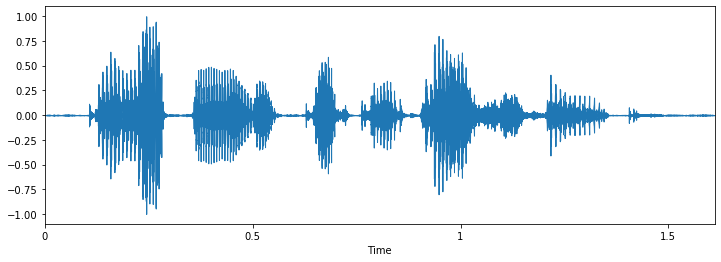

In [128]:
plt.figure(figsize=(12, 4))
librosa.display.waveplot(data[1], sr=sampling_rate)

In [130]:
#data prep
    # link = self.wav_file_location + self.wav_filename
    # data = wav.read(link)

In [131]:
# Feature Extraction
mfcc_features = []
for row in data:
    mfcc = np.mean(librosa.feature.mfcc(y=row, sr=sampling_rate, n_mfcc=40).T,axis=0) 
    mfcc_features.append(mfcc)

In [197]:
# Data Conversion
from sklearn.preprocessing import LabelEncoder

X = np.array(mfcc_features)
Y = np.array(["F", "N", "W", "F"])

lb = LabelEncoder()
Y = np_utils.to_categorical(lb.fit_transform(Y), num_classes=7)

In [198]:
print(X.shape)
print(Y.shape)
X = X.reshape((4, 40, 1))
print(X.shape)
X3D = X.reshape((4, 40, 1, 1))
print(X3D.shape)

(4, 40)
(4, 7)
(4, 40, 1)
(4, 40, 1, 1)


In [199]:
input = Input(shape=(40, 1,))

model = Conv1D(filters=32, kernel_size=3, strides=4, padding='same', activation='elu')(input)
model = BatchNormalization()(model)
model = MaxPool1D(2, padding='same')(model)

model = LSTM(64)(model)
output = Dense(32, activation='relu')(model)

out = Dense(3, activation='softmax')(output)
model = Model(inputs=input, outputs=out)
model.compile(loss = 'mse', optimizer=Adam(lr=learning_rate))

In [200]:
model.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        (None, 40, 1)             0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 10, 32)            128       
_________________________________________________________________
batch_normalization_87 (Batc (None, 10, 32)            128       
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 5, 32)             0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 64)                24832     
_________________________________________________________________
dense_33 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_34 (Dense)             (None, 3)                 99 

In [201]:
## Recommended model structure by a paper with the highest accuracy for EmoDB
input = Input(shape=(X3D.shape[1], X3D.shape[2], X3D.shape[3], ))

model = Conv2D(32, kernel_size=(7,7), strides=4, activation='elu', padding='same')(input)
model = BatchNormalization()(model)
model = MaxPool2D((2,2), padding='same')(model)
model = Conv2D(32, kernel_size=(3,3), strides=2, activation='elu', padding='same')(model)
model = BatchNormalization()(model)
model = MaxPool2D((2,2), padding='same')(model)
model = Conv2D(16, kernel_size=(3,3), strides=1, activation='elu', padding='same')(model)
model = BatchNormalization()(model)
model = MaxPool2D((2,2), padding='same')(model)
model = Conv2D(16, kernel_size=(3,3), strides=1, activation='elu', padding='same')(model)
model = BatchNormalization()(model)
model = MaxPool2D((2,2), padding='same')(model)

print(model.shape)
model = Reshape((16, 1,))(model)
print(model.shape)

model = LSTM(64)(model)
output = Dense(32, activation='relu')(model)

out = Dense(nr_emotions, activation='softmax')(output)
model = Model(inputs=input, outputs=out)
model.compile(loss = 'mse', optimizer=Adam(lr=learning_rate))

(?, 1, 1, 16)
(?, 16, 1)


In [202]:
model.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        (None, 40, 1, 1)          0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 10, 1, 32)         1600      
_________________________________________________________________
batch_normalization_88 (Batc (None, 10, 1, 32)         128       
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 5, 1, 32)          0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 3, 1, 32)          9248      
_________________________________________________________________
batch_normalization_89 (Batc (None, 3, 1, 32)          128       
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 2, 1, 32)          0  

In [203]:
# model.fit(x=X, y=Y, epochs=totalEpisodes)
model.fit(x=X3D, y=Y, epochs=totalEpisodes)

Epoch 1/10
4/4 [==============================] - 2s 600ms/step - loss: 0.1224
Epoch 2/10
4/4 [==============================] - 0s 5ms/step - loss: 0.1213
Epoch 3/10
4/4 [==============================] - 0s 7ms/step - loss: 0.1206
Epoch 4/10
4/4 [==============================] - 0s 6ms/step - loss: 0.1197
Epoch 5/10
4/4 [==============================] - 0s 6ms/step - loss: 0.1188
Epoch 6/10
4/4 [==============================] - 0s 6ms/step - loss: 0.1178
Epoch 7/10
4/4 [==============================] - 0s 6ms/step - loss: 0.1166
Epoch 8/10
4/4 [==============================] - 0s 7ms/step - loss: 0.1154
Epoch 9/10
4/4 [==============================] - 0s 7ms/step - loss: 0.1142
Epoch 10/10
4/4 [==============================] - 0s 5ms/step - loss: 0.1128


In [206]:
if LOAD_PROGRESS_FROM_MODEL:
    model.load_weights("app_model/model.h5")
    print("TotalEpisodes: " + str(totalEpisodes))
    print("Loaded model from disk")

if SAVE_PROGRESS_TO_MODEL:
    model.save_weights("app_model/model.h5")
    print("TotalEpisodes: " + str(totalEpisodes))
    print("Saved model to disk")

TotalEpisodes: 10
Saved model to disk
